In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches
import matplotlib.ticker as tkrimport 
import numpy as np
import pandas as pd
import re
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
YEARS = ['2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023']

file_path = "data/OPENDATANC/"

# Open CSV file in pandas
column_selected = ['SECTEUR_CONSO','SOUS_SECTEUR_CONSO','FAMILLE_PRODUIT','SOUS_FAMILLE','VARIETE',\
                   'CATEGORIE','DEPARTEMENT','CONDITIONNEMENT','COND_UNITE_LIBELLE_COURT','PRIX_RELEVE',\
                    'RAISON_SOCIALE','QUARTIER','COMMUNE','point_geo']
# mise en format catégorie pour réduire la taille
column_cat = ['SECTEUR_CONSO','SOUS_SECTEUR_CONSO','FAMILLE_PRODUIT','SOUS_FAMILLE','VARIETE',\
                   'CATEGORIE','DEPARTEMENT','COND_UNITE_LIBELLE_COURT',\
                    'RAISON_SOCIALE','QUARTIER','COMMUNE']


dict_df = {}
for year in YEARS:
    print(year)
    file_name = "OPENDATANC_prix_produits_alimentaires_{year}.csv".format(year=year)
    df = pd.read_csv(file_path + file_name, usecols=column_selected) # Only columns selected
    df['ANNEE'] = year
    for col in column_cat:
        df[col] = df[col].astype('category')
    
    dict_df[year]=df

2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


In [3]:
df_raw=pd.concat(dict_df.values())
print(len(df_raw.index),len(df_raw.columns.to_list()),df_raw.columns.to_list())

# for el in df_raw.columns.to_list()[12:13]:
#     print(el)

#     print(len(df_raw[el].unique()), df_raw[el].unique())

51882946 15 ['SECTEUR_CONSO', 'SOUS_SECTEUR_CONSO', 'FAMILLE_PRODUIT', 'SOUS_FAMILLE', 'VARIETE', 'CATEGORIE', 'DEPARTEMENT', 'CONDITIONNEMENT', 'COND_UNITE_LIBELLE_COURT', 'PRIX_RELEVE', 'RAISON_SOCIALE', 'QUARTIER', 'COMMUNE', 'point_geo', 'ANNEE']


In [4]:
# Add lat & lon columns from point_geo
df_raw['point_geo'] = df_raw['point_geo'].astype(str)
df_raw[['lat', 'lon']] = df_raw['point_geo'].str.split(',', expand=True)
df_raw.lat = df_raw.lat.astype(float)
df_raw.lon = df_raw.lon.astype(float)
# df_raw = df_raw.drop(columns=['point_geo'])

df_net = df_raw

# print(df_net.head())
# print(df_net.dtypes)

In [5]:
## Analyse n°1
df_net_dep = df_net[df_net.CATEGORIE != 'SERVICE']
df_rgb_departement = df_net_dep.groupby(['DEPARTEMENT','CATEGORIE']).agg(count_trans=('PRIX_RELEVE', 'count'), sum_trans=('PRIX_RELEVE', 'sum'))
df_rgb_departement['count_trans_pct'] = df_rgb_departement['count_trans']/df_rgb_departement['count_trans'].sum()*100
df_rgb_departement['sum_trans_pct'] = df_rgb_departement['sum_trans']/df_rgb_departement['sum_trans'].sum()*100
df_level_1 = df_rgb_departement.groupby(level=[0]).sum()
df_level_2 = df_rgb_departement.groupby(level=[0,1]).sum()

print(df_rgb_departement)

                       count_trans     sum_trans  count_trans_pct  \
DEPARTEMENT CATEGORIE                                               
Frais       IMPORT         4309159  2.440933e+09         8.445999   
            LOCAL          2291417  1.367510e+09         4.491202   
Sec         IMPORT        34087038  1.430944e+10        66.810968   
            LOCAL          6199188  3.822054e+09        12.150476   
Surgelés    IMPORT         3079985  2.246126e+09         6.036804   
            LOCAL          1053336  9.272319e+08         2.064550   

                       sum_trans_pct  
DEPARTEMENT CATEGORIE                 
Frais       IMPORT          9.719685  
            LOCAL           5.445363  
Sec         IMPORT         56.979539  
            LOCAL          15.219245  
Surgelés    IMPORT          8.943972  
            LOCAL           3.692196  


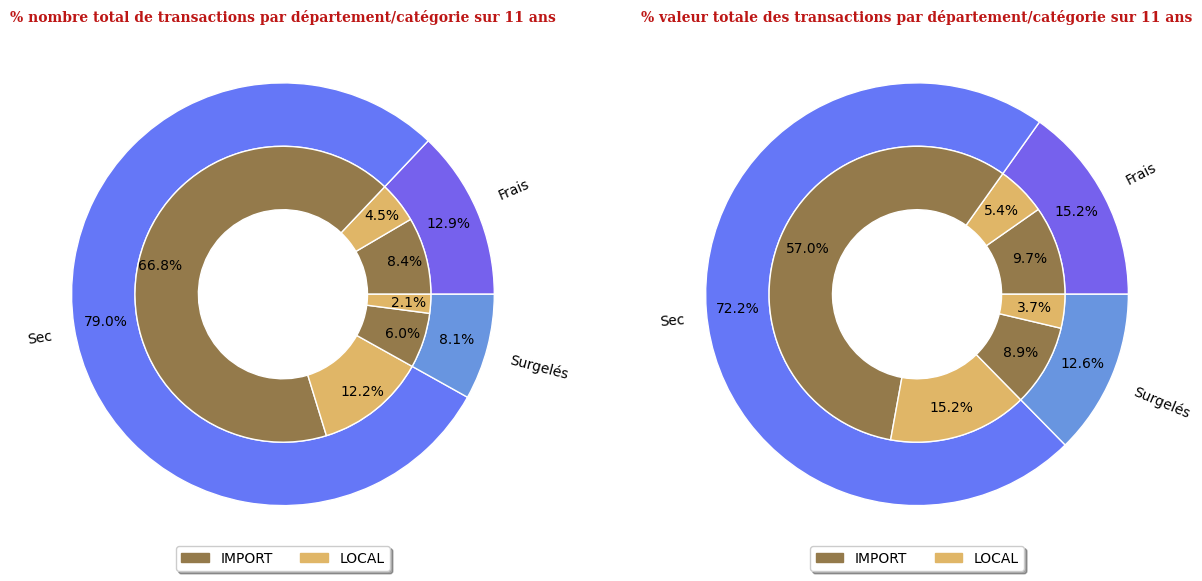

In [6]:
# Graphique n°1

title_family = 'serif'  # 'serif' | 'sans-serif' | 'cursive' | 'fantasy' | 'monospace'
title_color = '#BD1615' 
title_weight = 'bold' # 'normal' | 'bold' | 'heavy' | 'light' | 'ultrabold' | 'ultralight'
title_size = 10
title_x = 0.5
title_y = 1

fig, axe1 = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), sharex=True)

## 1
graph_title_1 = "% nombre total de transactions par département/catégorie sur 11 ans"

axe1[0].set_title(graph_title_1, x=title_x, y=title_y, fontdict={
               'family': title_family, 'color': title_color, 'weight': title_weight, 'size': title_size})

size = 0.3

outer_colors = ['#7661ED','#6577F7','#6895E0']
inner_colors = ['#947A4B','#E0B667']

inner_labels_1 = df_level_1.index.get_level_values(0)
inner_labels_2 = df_level_2.index.get_level_values(1)

def autopct_tunning(p): return '{:1.1f}%'.format(p) if p > 1 else None

axe1[0].pie(df_level_1['count_trans_pct'], 
            radius=1, 
            labels=inner_labels_1,
            autopct=autopct_tunning,
            colors=outer_colors,
            rotatelabels=True,
            wedgeprops=dict(width=size, edgecolor='w'),
            pctdistance=0.85)

axe1[0].pie(df_level_2['count_trans_pct'], 
            radius=1-size, 
            autopct=autopct_tunning,
            colors=inner_colors,
            rotatelabels=True,
            wedgeprops=dict(width=size, edgecolor='w'),
            pctdistance=0.85)


# Legend
importation = mpatches.Patch(color='#947A4B', label='IMPORT')
local = mpatches.Patch(color='#E0B667', label='LOCAL')
axe1[0].legend(handles=[importation,local],
               loc="center", 
               bbox_to_anchor=(0, 0, 1, 0),
               ncol=2,
               fancybox=True,
               shadow=True)



## 2
graph_title_2 = "% valeur totale des transactions par département/catégorie sur 11 ans"
axe1[1].set_title(graph_title_2, x=title_x, y=title_y, fontdict={
               'family': title_family, 'color': title_color, 'weight': title_weight, 'size': title_size})

size = 0.3

outer_colors = ['#7661ED','#6577F7','#6895E0']
inner_colors = ['#947A4B','#E0B667']

inner_labels_1 = df_level_1.index.get_level_values(0)
inner_labels_2 = df_level_2.index.get_level_values(1)

def autopct_tunning(p): return '{:1.1f}%'.format(p) if p > 1 else None

axe1[1].pie(df_level_1['sum_trans_pct'], 
            radius=1, 
            labels=inner_labels_1,
            autopct=autopct_tunning,
            colors=outer_colors,
            rotatelabels=True,
            wedgeprops=dict(width=size, edgecolor='w'),
            pctdistance=0.85)

axe1[1].pie(df_level_2['sum_trans_pct'], 
            radius=1-size, 
            autopct=autopct_tunning,
            colors=inner_colors,
            rotatelabels=True,
            wedgeprops=dict(width=size, edgecolor='w'),
            pctdistance=0.80)


# Legend
importation = mpatches.Patch(color='#947A4B', label='IMPORT')
local = mpatches.Patch(color='#E0B667', label='LOCAL')
axe1[1].legend(handles=[importation,local],
               loc="center", 
               bbox_to_anchor=(0, 0, 1, 0),
               ncol=2,
               fancybox=True,
               shadow=True)

plt.show()

In [7]:
## Analyse n°2
df_rgb_secteur = df_net.groupby(['SECTEUR_CONSO']).agg(count_trans=('PRIX_RELEVE', 'count'), sum_trans=('PRIX_RELEVE', 'sum'))
df_rgb_secteur['count_trans_pct'] = df_rgb_secteur['count_trans']/df_rgb_secteur['count_trans'].sum()*100
df_rgb_secteur['sum_trans_pct'] = df_rgb_secteur['sum_trans']/df_rgb_secteur['sum_trans'].sum()*100
df_rgb_secteur['avg_trans_pct'] = df_rgb_secteur['sum_trans']/df_rgb_secteur['count_trans']
df_rgb_secteur=df_rgb_secteur.sort_values('count_trans')

# print(df_rgb_secteur)


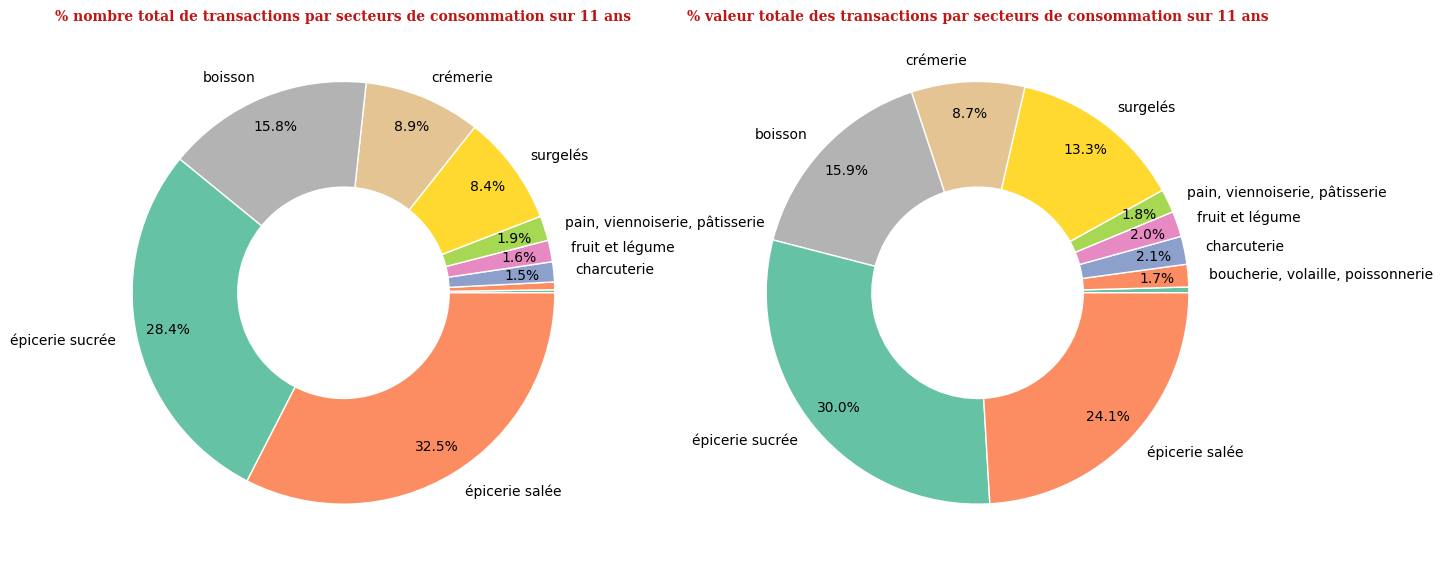

In [8]:
# Graphique n°2.1

title_family = 'serif'  # 'serif' | 'sans-serif' | 'cursive' | 'fantasy' | 'monospace'
title_color = '#BD1615'  
title_weight = 'bold' # 'normal' | 'bold' | 'heavy' | 'light' | 'ultrabold' | 'ultralight'
title_size = 10
title_x = 0.5
title_y = 1

fig, axe1 = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), sharex=True)

## 1
graph_title_1 = "% nombre total de transactions par secteurs de consommation sur 11 ans"

axe1[0].set_title(graph_title_1, x=title_x, y=title_y, fontdict={
               'family': title_family, 'color': title_color, 'weight': title_weight, 'size': title_size})

size = 0.5

def autopct_tunning(p): return '{:1.1f}%'.format(p) if p > 1 else None

axe1[0].pie(df_rgb_secteur['count_trans_pct'], 
            radius=1, 
            labels=[x if df_rgb_secteur.loc[df_rgb_secteur.index.values == x, 'count_trans_pct'].iloc[0] > 1 else '' for x in df_rgb_secteur.index.values],
            autopct=autopct_tunning,
            colors=sns.color_palette('Set2'),
            wedgeprops=dict(width=size, edgecolor='w'),
            pctdistance=0.85)




## 2
graph_title_2 = "% valeur totale des transactions par secteurs de consommation sur 11 ans"
axe1[1].set_title(graph_title_2, x=title_x, y=title_y, fontdict={
               'family': title_family, 'color': title_color, 'weight': title_weight, 'size': title_size})

size = 0.5

def autopct_tunning(p): return '{:1.1f}%'.format(p) if p > 1 else None

axe1[1].pie(df_rgb_secteur['sum_trans_pct'], 
            radius=1, 
            labels=[x if df_rgb_secteur.loc[df_rgb_secteur.index.values == x, 'sum_trans_pct'].iloc[0] > 1 else '' for x in df_rgb_secteur.index.values],
            autopct=autopct_tunning,
            colors=sns.color_palette('Set2'),
            wedgeprops=dict(width=size, edgecolor='w'),
            pctdistance=0.85)


plt.show()

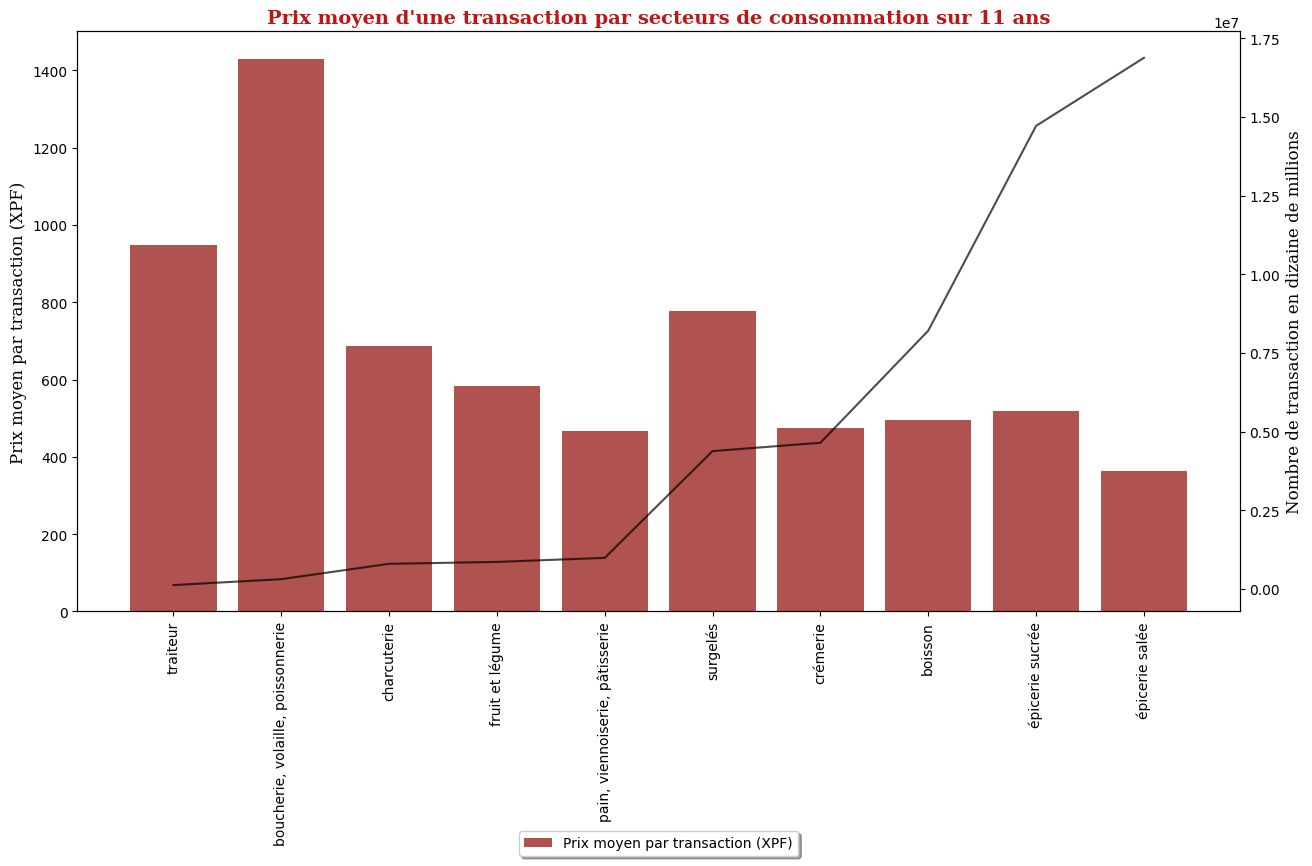

In [9]:
# Graphique
# Paramètres Titre
graph_title = "Prix moyen d'une transaction par secteurs de consommation sur 11 ans"
title_family = 'serif'   # 'serif' | 'sans-serif' | 'cursive' | 'fantasy' | 'monospace'
title_color = '#BD1615' 
title_weight = 'bold'     # 'normal' | 'bold' | 'heavy' | 'light' | 'ultrabold' | 'ultralight'
title_size = 14
title_x = 0.5
title_y = 1

# Paramètres d'axes
xtick_rotation = 90

xy_label_family = 'serif'
xy_label_color = 'black'
xy_label_weight = 'light'
xy_label_size = 12

y1_color = '#8E0806'
y1_alpha = 0.7
y1_label = 'Prix moyen par transaction (XPF)'

y2_color = 'black'
y2_alpha = 0.7
y2_label = 'Nombre de transaction en dizaine de millions'

graph_linestyle = 'solid'

# Paramètres grille
grid_alpha = 0.5

###########################################################################################################
fig, axe1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharex=True)
fig.subplots_adjust(bottom=0.3)

plt.xticks(rotation=xtick_rotation)

# Axe n°1
axe1.set_title(graph_title, x=title_x, y=title_y, fontdict={'family': title_family, 'color': title_color, 'weight': title_weight, 'size': title_size})
axe1.set_ylabel(y1_label, fontdict={'family': xy_label_family, 'color': xy_label_color, 'weight': xy_label_weight, 'size': xy_label_size})

axe1.bar(df_rgb_secteur.index.values, df_rgb_secteur.avg_trans_pct,color=y1_color, alpha=y1_alpha, label=y1_label)
axe1.legend(loc="center", bbox_to_anchor=(0, 0, 1, -0.8),ncol=1, fancybox=True, shadow=True)
# axe1.grid(True, alpha=grid_alpha)

# Axe n°2
axe2 = axe1.twinx()
axe2.set_ylabel(y2_label, fontdict={'family': xy_label_family, 'color': xy_label_color, 'weight': xy_label_weight, 'size': xy_label_size})

axe2.plot(df_rgb_secteur.index.values, df_rgb_secteur.count_trans, color=y2_color, linestyle=graph_linestyle, alpha=y2_alpha, label=y2_label)

# axe2.legend(loc="center", bbox_to_anchor=(0, 0, 1, -0.6),ncol=1, fancybox=True, shadow=True)



In [10]:
# Analyse n°3
df_rgb_sous_secteur = df_net.groupby(['SOUS_SECTEUR_CONSO']).agg(count_trans=('PRIX_RELEVE', 'count'), sum_trans=('PRIX_RELEVE', 'sum'),avg_trans=('PRIX_RELEVE', 'mean'))
df_rgb_sous_secteur['count_trans_pct'] = df_rgb_sous_secteur['count_trans']/df_rgb_sous_secteur['count_trans'].sum()*100
df_rgb_sous_secteur['sum_trans_pct'] = df_rgb_sous_secteur['sum_trans']/df_rgb_sous_secteur['sum_trans'].sum()*100

df_rgb_sous_secteur_count_top10=df_rgb_sous_secteur.sort_values('count_trans', ascending=False).head(10)
df_rgb_sous_secteur_sum_top10=df_rgb_sous_secteur.sort_values('sum_trans', ascending=False).head(10)
df_rgb_sous_secteur_avg_top10=df_rgb_sous_secteur.sort_values('avg_trans', ascending=False).head(10)

global_sous_secteur_count_top10 = df_rgb_sous_secteur_count_top10.index.to_list()
global_sous_secteur_sum_top10 = df_rgb_sous_secteur_sum_top10.index.to_list()
global_sous_secteur_avg_top10 = df_rgb_sous_secteur_avg_top10.index.to_list()

#  'SOUS_SECTEUR_CONSO', 'FAMILLE_PRODUIT', 'SOUS_FAMILLE', 'VARIETE',

In [11]:
df_net_sous_secteur_count_top10 = df_net[df_net['SOUS_SECTEUR_CONSO'].isin(global_sous_secteur_count_top10)]

df_net_sous_secteur_count_top10_i = df_net_sous_secteur_count_top10[df_net_sous_secteur_count_top10['CATEGORIE']=='IMPORT']
df_net_sous_secteur_count_top10_l = df_net_sous_secteur_count_top10[df_net_sous_secteur_count_top10['CATEGORIE']=='LOCAL']

df_net_sous_secteur_count_top10_i = df_net_sous_secteur_count_top10_i.groupby(['SOUS_SECTEUR_CONSO']).agg(count_trans=('PRIX_RELEVE', 'count'), sum_trans=('PRIX_RELEVE', 'sum'),avg_trans=('PRIX_RELEVE', 'mean'))
df_net_sous_secteur_count_top10_i['count_trans_pct'] = df_net_sous_secteur_count_top10_i['count_trans']/df_rgb_sous_secteur['count_trans'].sum()*100
df_net_sous_secteur_count_top10_i['sum_trans_pct'] = df_net_sous_secteur_count_top10_i['sum_trans']/df_rgb_sous_secteur['sum_trans'].sum()*100
df_net_sous_secteur_count_top10_i = df_net_sous_secteur_count_top10_i.loc[global_sous_secteur_count_top10]

df_net_sous_secteur_count_top10_l = df_net_sous_secteur_count_top10_l.groupby(['SOUS_SECTEUR_CONSO']).agg(count_trans=('PRIX_RELEVE', 'count'), sum_trans=('PRIX_RELEVE', 'sum'),avg_trans=('PRIX_RELEVE', 'mean'))
df_net_sous_secteur_count_top10_l['count_trans_pct'] = df_net_sous_secteur_count_top10_l['count_trans']/df_rgb_sous_secteur['count_trans'].sum()*100
df_net_sous_secteur_count_top10_l['sum_trans_pct'] = df_net_sous_secteur_count_top10_l['sum_trans']/df_rgb_sous_secteur['sum_trans'].sum()*100
df_net_sous_secteur_count_top10_l = df_net_sous_secteur_count_top10_l.loc[global_sous_secteur_count_top10]

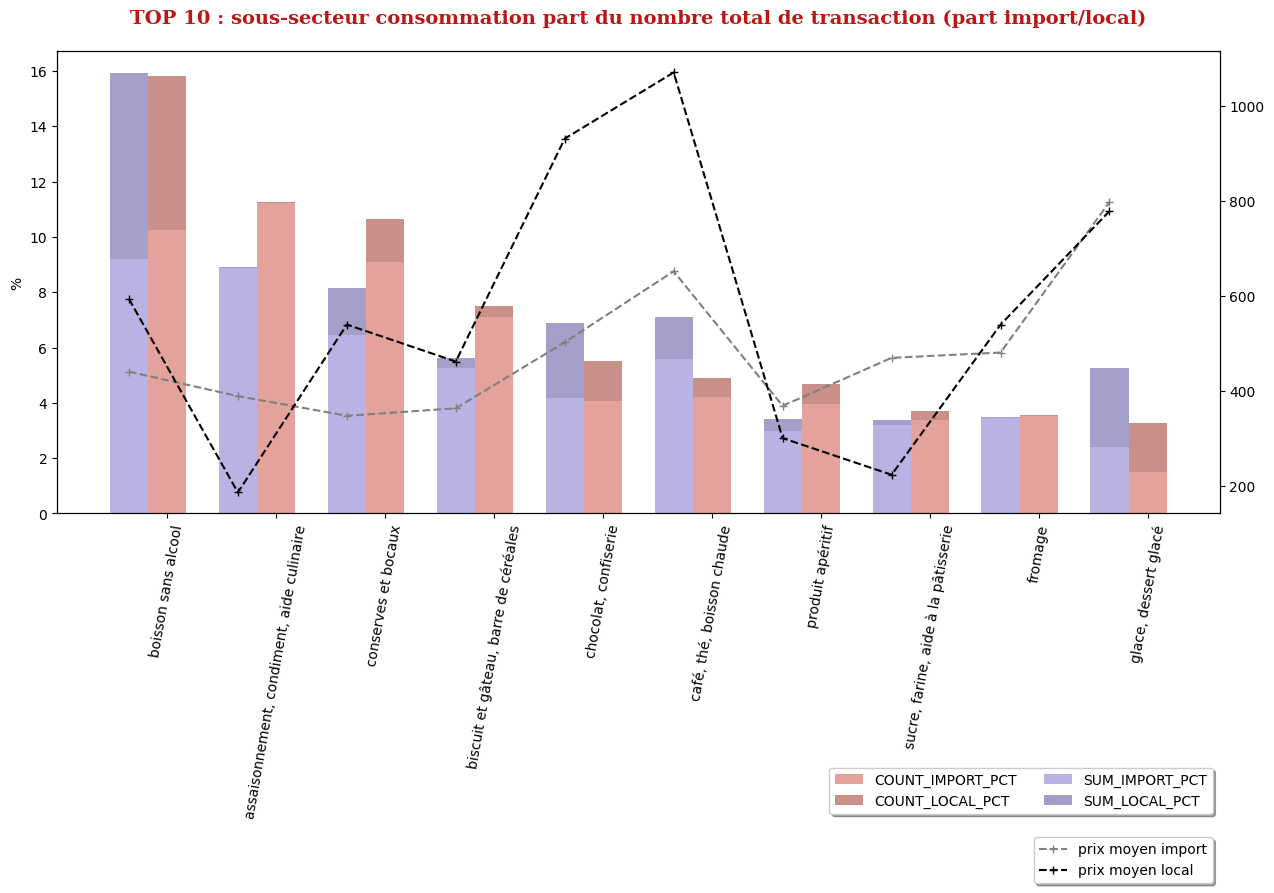

In [12]:
## GRAPHIQUE 3.1
TITLE = "TOP 10 : sous-secteur consommation part du nombre total de transaction (part import/local)"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
plt.xticks(rotation=90)
ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 14},pad=20)


width = 0.35
categories = df_net_sous_secteur_count_top10_i.index.to_list()
bar_colors_c = ['#E3A29B', '#C98F89']
bar_colors_s = ['#B8B3E3', '#A39FC9']

count_transaction= {"COUNT_IMPORT_PCT": df_net_sous_secteur_count_top10_i['count_trans_pct'].to_list(),
                    "COUNT_LOCAL_PCT": df_net_sous_secteur_count_top10_l['count_trans_pct'].to_list(),
                   }

sum_transaction= {"SUM_IMPORT_PCT": df_net_sous_secteur_count_top10_i['sum_trans_pct'].to_list(),
                  "SUM_LOCAL_PCT": df_net_sous_secteur_count_top10_l['sum_trans_pct'].to_list(),
                   }


x = np.arange(len(categories))

i=0
bottom_c = np.zeros(len(df_net_sous_secteur_count_top10_i.index.to_list()))
for boolean, pourcentage in count_transaction.items():
    p = ax.bar(x+width, pourcentage, width, label=boolean, bottom=bottom_c, color=bar_colors_c[i])
    bottom_c += pourcentage
    i += 1

j=0
bottom_s = np.zeros(len(df_net_sous_secteur_count_top10_i.index.to_list()))
for boolean, pourcentage in sum_transaction.items():
    p = ax.bar(x, pourcentage, width, label=boolean, bottom=bottom_s, color=bar_colors_s[j])
    bottom_s += pourcentage
    j += 1


ax2 = ax.twinx()
ax2.plot(df_net_sous_secteur_count_top10_i.index.values, df_net_sous_secteur_count_top10_i['avg_trans'], 'grey',linestyle='--', marker='+',linewidth=1.5, label='prix moyen import')
ax2.plot(df_net_sous_secteur_count_top10_l.index.values, df_net_sous_secteur_count_top10_l['avg_trans'], 'black',linestyle='--', marker='+',linewidth=1.5, label='prix moyen local')
# ax2.axhline(0, color='red', alpha=0.2)

ax.set_ylabel('%')

ax.set_xticks(x + width, categories)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=80)
ax.legend(loc="right",bbox_to_anchor=(0,0,1,-1.2), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,1,-1.5), ncol=1, fancybox=True, shadow=True)

In [13]:
df_net_sous_secteur_sum_top10 = df_net[df_net['SOUS_SECTEUR_CONSO'].isin(global_sous_secteur_sum_top10)]

df_net_sous_secteur_sum_top10_i = df_net_sous_secteur_sum_top10[df_net_sous_secteur_sum_top10['CATEGORIE']=='IMPORT']
df_net_sous_secteur_sum_top10_l = df_net_sous_secteur_sum_top10[df_net_sous_secteur_sum_top10['CATEGORIE']=='LOCAL']

df_net_sous_secteur_sum_top10_i = df_net_sous_secteur_sum_top10_i.groupby(['SOUS_SECTEUR_CONSO']).agg(count_trans=('PRIX_RELEVE', 'count'), sum_trans=('PRIX_RELEVE', 'sum'),avg_trans=('PRIX_RELEVE', 'mean'))
df_net_sous_secteur_sum_top10_i['count_trans_pct'] = df_net_sous_secteur_sum_top10_i['count_trans']/df_rgb_sous_secteur['count_trans'].sum()*100
df_net_sous_secteur_sum_top10_i['sum_trans_pct'] = df_net_sous_secteur_sum_top10_i['sum_trans']/df_rgb_sous_secteur['sum_trans'].sum()*100
df_net_sous_secteur_sum_top10_i = df_net_sous_secteur_sum_top10_i.loc[global_sous_secteur_sum_top10]

df_net_sous_secteur_sum_top10_l = df_net_sous_secteur_sum_top10_l.groupby(['SOUS_SECTEUR_CONSO']).agg(count_trans=('PRIX_RELEVE', 'count'), sum_trans=('PRIX_RELEVE', 'sum'),avg_trans=('PRIX_RELEVE', 'mean'))
df_net_sous_secteur_sum_top10_l['count_trans_pct'] = df_net_sous_secteur_sum_top10_l['count_trans']/df_rgb_sous_secteur['count_trans'].sum()*100
df_net_sous_secteur_sum_top10_l['sum_trans_pct'] = df_net_sous_secteur_sum_top10_l['sum_trans']/df_rgb_sous_secteur['sum_trans'].sum()*100
df_net_sous_secteur_sum_top10_l = df_net_sous_secteur_sum_top10_l.loc[global_sous_secteur_sum_top10]

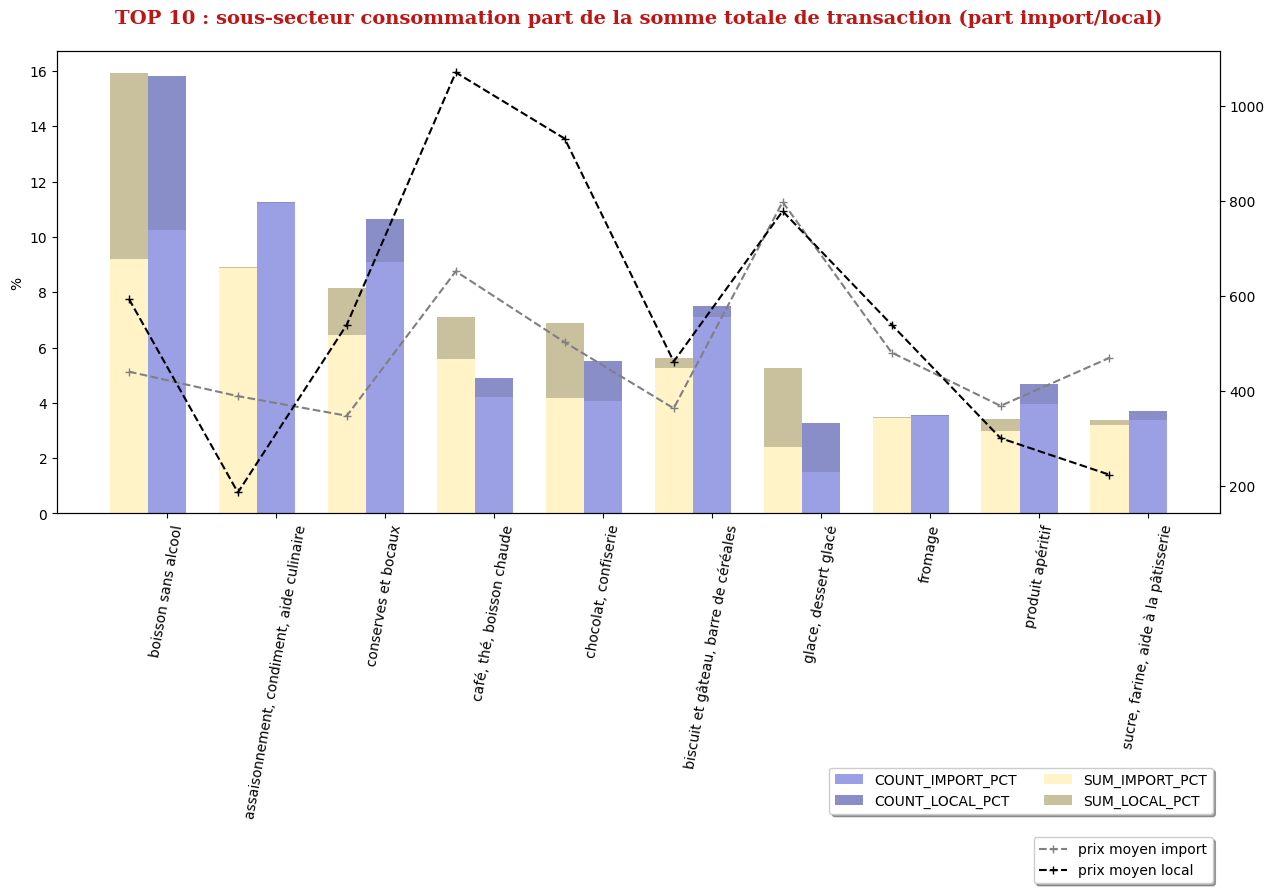

In [14]:
## GRAPHIQUE 3.2
TITLE = "TOP 10 : sous-secteur consommation part de la somme totale de transaction (part import/local)"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
plt.xticks(rotation=90)
ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 14},pad=20)


width = 0.35
categories = df_net_sous_secteur_sum_top10_l.index.to_list()
bar_colors_c = ['#9AA0E3', '#898EC9']
bar_colors_s = ['#FFF3C7', '#C9C09D']

count_transaction= {"COUNT_IMPORT_PCT": df_net_sous_secteur_sum_top10_i['count_trans_pct'].to_list(),
                    "COUNT_LOCAL_PCT": df_net_sous_secteur_sum_top10_l['count_trans_pct'].to_list(),
                   }

sum_transaction= {"SUM_IMPORT_PCT": df_net_sous_secteur_sum_top10_i['sum_trans_pct'].to_list(),
                  "SUM_LOCAL_PCT": df_net_sous_secteur_sum_top10_l['sum_trans_pct'].to_list(),
                   }


x = np.arange(len(categories))

i=0
bottom_c = np.zeros(len(df_net_sous_secteur_sum_top10_i.index.to_list()))
for boolean, pourcentage in count_transaction.items():
    p = ax.bar(x+width, pourcentage, width, label=boolean, bottom=bottom_c, color=bar_colors_c[i])
    bottom_c += pourcentage
    i += 1

j=0
bottom_s = np.zeros(len(df_net_sous_secteur_sum_top10_i.index.to_list()))
for boolean, pourcentage in sum_transaction.items():
    p = ax.bar(x, pourcentage, width, label=boolean, bottom=bottom_s, color=bar_colors_s[j])
    bottom_s += pourcentage
    j += 1


ax2 = ax.twinx()
ax2.plot(df_net_sous_secteur_sum_top10_i.index.values, df_net_sous_secteur_sum_top10_i['avg_trans'], 'grey',linestyle='--', marker='+',linewidth=1.5, label='prix moyen import')
ax2.plot(df_net_sous_secteur_sum_top10_l.index.values, df_net_sous_secteur_sum_top10_l['avg_trans'], 'black',linestyle='--', marker='+',linewidth=1.5, label='prix moyen local')
# ax2.axhline(0, color='red', alpha=0.2)

ax.set_ylabel('%')

ax.set_xticks(x + width, categories)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=80)
ax.legend(loc="right",bbox_to_anchor=(0,0,1,-1.2), ncol=2, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,1,-1.5), ncol=1, fancybox=True, shadow=True)

In [16]:
# Analyse n°4
df_rgb_famille_produit = df_net.groupby(['FAMILLE_PRODUIT']).agg(count_trans=('PRIX_RELEVE', 'count'), sum_trans=('PRIX_RELEVE', 'sum'),avg_trans=('PRIX_RELEVE', 'mean'))
df_rgb_famille_produit['count_trans_pct'] = df_rgb_famille_produit['count_trans']/df_rgb_famille_produit['count_trans'].sum()*100
df_rgb_famille_produit['sum_trans_pct'] = df_rgb_famille_produit['sum_trans']/df_rgb_famille_produit['sum_trans'].sum()*100

df_rgb_famille_produit_count_top10=df_rgb_famille_produit.sort_values('count_trans', ascending=False).head(10)
df_rgb_famille_produit_sum_top10=df_rgb_famille_produit.sort_values('sum_trans', ascending=False).head(10)
df_rgb_famille_produit_avg_top10=df_rgb_famille_produit.sort_values('avg_trans', ascending=False).head(10)

global_famille_produit_count_top10 = df_rgb_famille_produit_count_top10.index.to_list()
global_famille_produit_sum_top10 = df_rgb_famille_produit_sum_top10.index.to_list()
global_famille_produit_avg_top10 = df_rgb_famille_produit_avg_top10.index.to_list()

#  'SOUS_SECTEUR_CONSO', 'FAMILLE_PRODUIT', 'SOUS_FAMILLE', 'VARIETE',

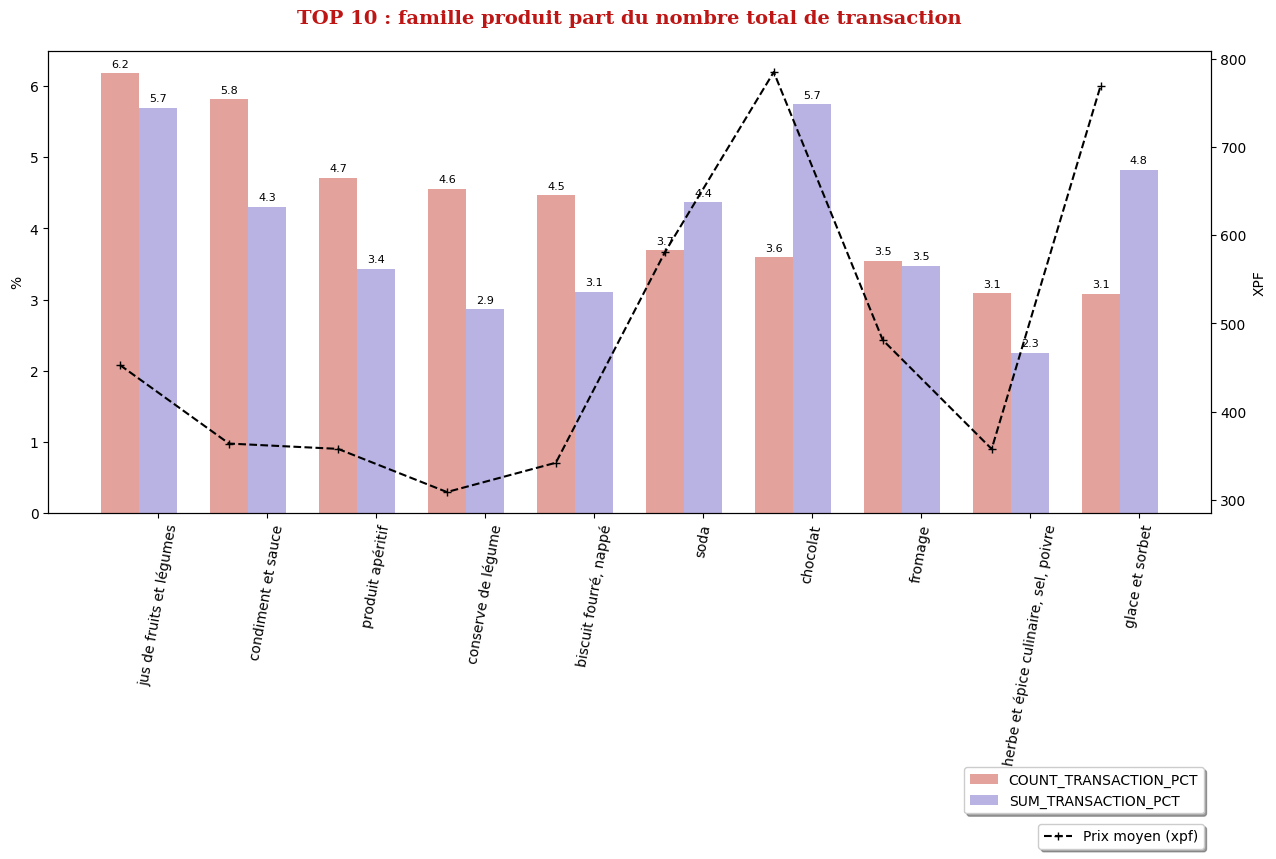

In [28]:
## GRAPHIQUE 4.1
TITLE = "TOP 10 : famille produit part du nombre total de transaction"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 14},pad=20)

## 1
categories = df_rgb_famille_produit_count_top10.index.to_list()
value = {'COUNT_TRANSACTION_PCT': df_rgb_famille_produit_count_top10['count_trans_pct'].to_list(),
       'SUM_TRANSACTION_PCT': df_rgb_famille_produit_count_top10['sum_trans_pct'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0
bar_colors = ['#E3A29B', '#B8B3E3']

i=0
for attribute, measurement in value.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax.bar_label(rects, padding=3, fontsize=8,fmt='%.1f')
    multiplier += 1
    i+=1

ax2 = ax.twinx()
ax2.plot(df_rgb_famille_produit_count_top10.index.values, df_rgb_famille_produit_count_top10['avg_trans'], 'black',linestyle='--', marker='+',linewidth=1.5, label='Prix moyen (xpf)')

ax.set_ylabel('%')
ax2.set_ylabel('XPF')

ax.set_xticks(x + width, categories)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=80)
ax.legend(loc="right",bbox_to_anchor=(0,0,1,-1.2), ncol=1, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,1,-1.4), ncol=1, fancybox=True, shadow=True)

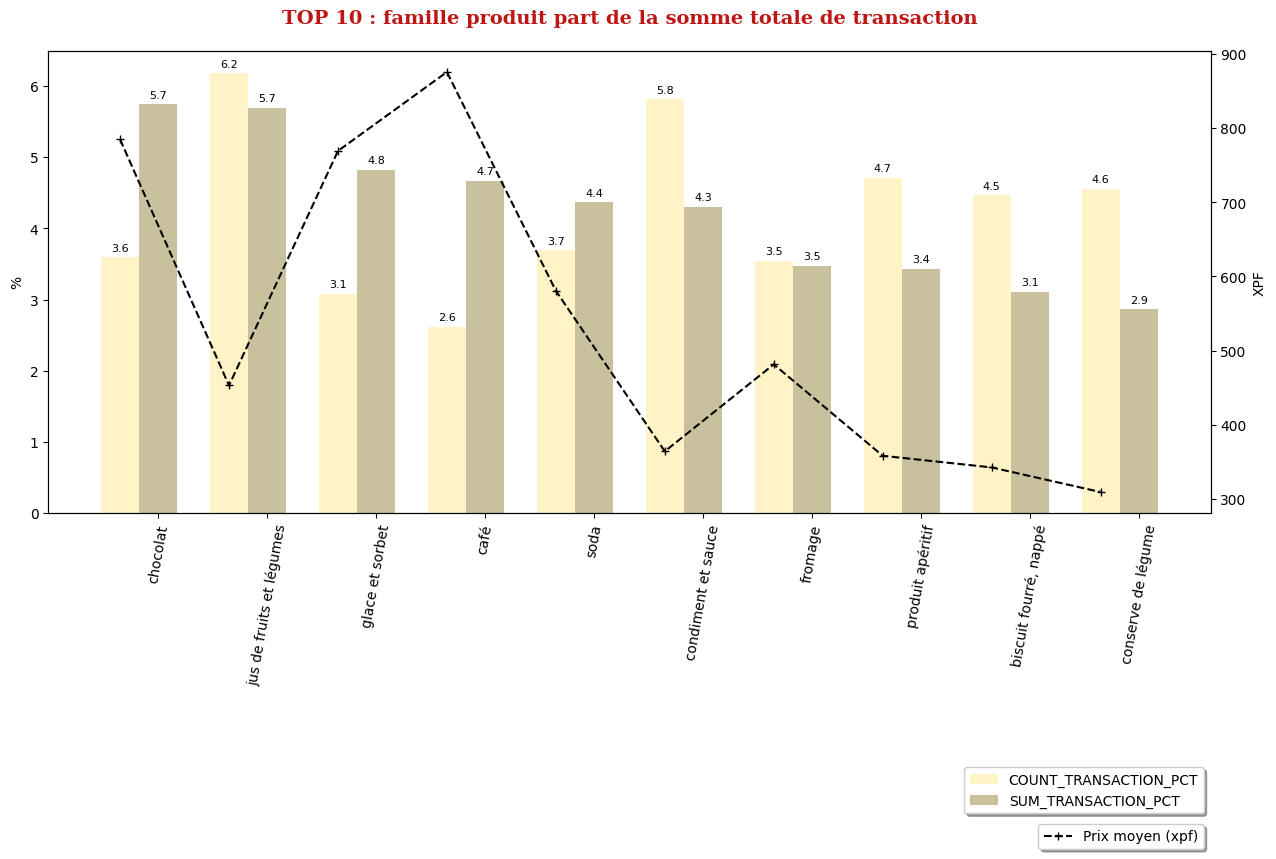

In [31]:
## GRAPHIQUE 4.2
TITLE = "TOP 10 : famille produit part de la somme totale de transaction"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 14},pad=20)

## 1
categories = df_rgb_famille_produit_sum_top10.index.to_list()
value = {'COUNT_TRANSACTION_PCT': df_rgb_famille_produit_sum_top10['count_trans_pct'].to_list(),
       'SUM_TRANSACTION_PCT': df_rgb_famille_produit_sum_top10['sum_trans_pct'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0
bar_colors = ['#FFF3C7', '#C9C09D']

i=0
for attribute, measurement in value.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax.bar_label(rects, padding=3, fontsize=8,fmt='%.1f')
    multiplier += 1
    i+=1

ax2 = ax.twinx()
ax2.plot(df_rgb_famille_produit_sum_top10.index.values, df_rgb_famille_produit_sum_top10['avg_trans'], 'black',linestyle='--', marker='+',linewidth=1.5, label='Prix moyen (xpf)')

ax.set_ylabel('%')
ax2.set_ylabel('XPF')

ax.set_xticks(x + width, categories)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=80)
ax.legend(loc="right",bbox_to_anchor=(0,0,1,-1.2), ncol=1, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,1,-1.4), ncol=1, fancybox=True, shadow=True)

In [32]:
# Analyse n°5
df_rgb_famille_produit = df_net.groupby(['SOUS_FAMILLE']).agg(count_trans=('PRIX_RELEVE', 'count'), sum_trans=('PRIX_RELEVE', 'sum'),avg_trans=('PRIX_RELEVE', 'mean'))
df_rgb_famille_produit['count_trans_pct'] = df_rgb_famille_produit['count_trans']/df_rgb_famille_produit['count_trans'].sum()*100
df_rgb_famille_produit['sum_trans_pct'] = df_rgb_famille_produit['sum_trans']/df_rgb_famille_produit['sum_trans'].sum()*100

df_rgb_famille_produit_count_top10=df_rgb_famille_produit.sort_values('count_trans', ascending=False).head(10)
df_rgb_famille_produit_sum_top10=df_rgb_famille_produit.sort_values('sum_trans', ascending=False).head(10)
df_rgb_famille_produit_avg_top10=df_rgb_famille_produit.sort_values('avg_trans', ascending=False).head(10)

global_sous_famille_count_top10 = df_rgb_famille_produit_count_top10.index.to_list()
global_sous_famille_sum_top10 = df_rgb_famille_produit_sum_top10.index.to_list()
global_sous_famille_produit_avg_top10 = df_rgb_famille_produit_avg_top10.index.to_list()

#  'SOUS_SECTEUR_CONSO', 'FAMILLE_PRODUIT', 'SOUS_FAMILLE', 'VARIETE',

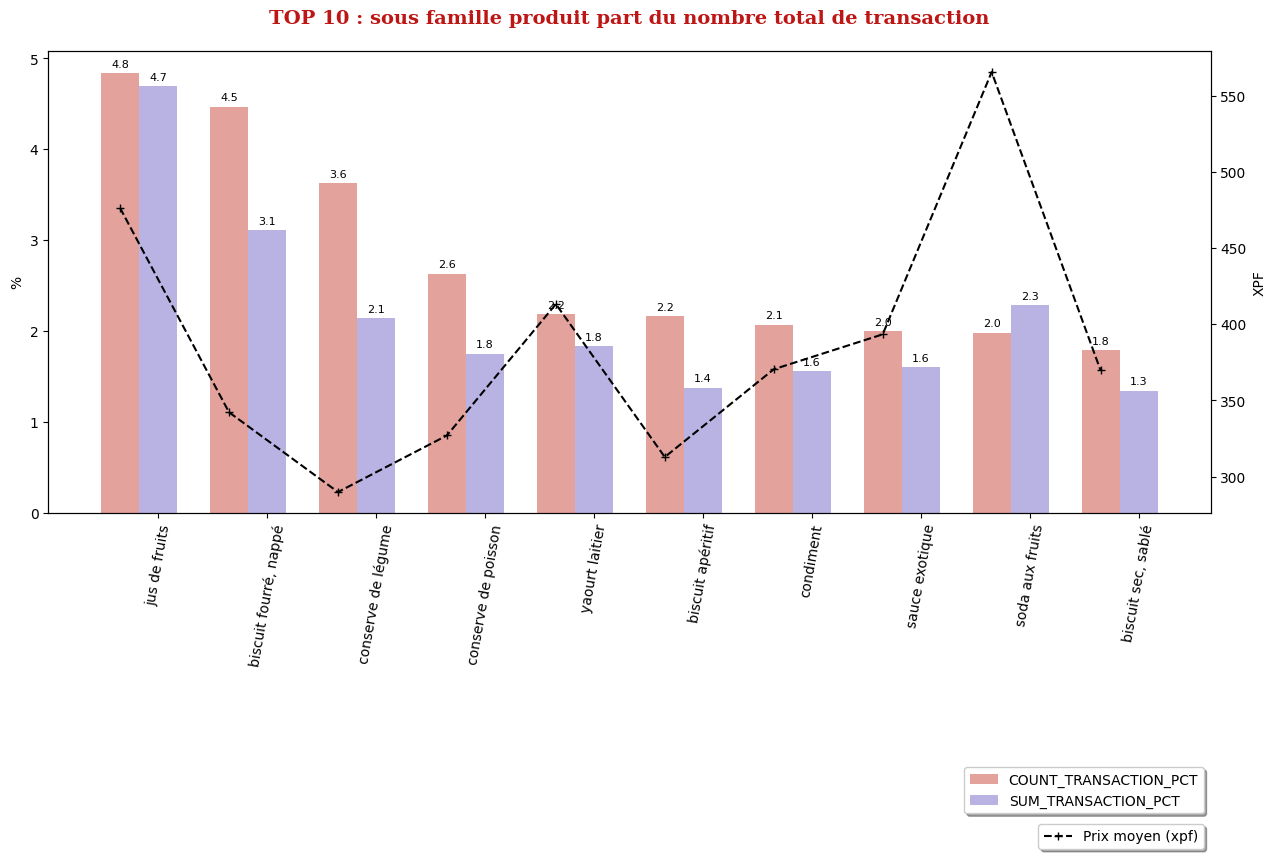

In [33]:
## GRAPHIQUE 5.1
TITLE = "TOP 10 : sous famille produit part du nombre total de transaction"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 14},pad=20)

## 1
categories = df_rgb_famille_produit_count_top10.index.to_list()
value = {'COUNT_TRANSACTION_PCT': df_rgb_famille_produit_count_top10['count_trans_pct'].to_list(),
       'SUM_TRANSACTION_PCT': df_rgb_famille_produit_count_top10['sum_trans_pct'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0
bar_colors = ['#E3A29B', '#B8B3E3']

i=0
for attribute, measurement in value.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax.bar_label(rects, padding=3, fontsize=8,fmt='%.1f')
    multiplier += 1
    i+=1

ax2 = ax.twinx()
ax2.plot(df_rgb_famille_produit_count_top10.index.values, df_rgb_famille_produit_count_top10['avg_trans'], 'black',linestyle='--', marker='+',linewidth=1.5, label='Prix moyen (xpf)')

ax.set_ylabel('%')
ax2.set_ylabel('XPF')

ax.set_xticks(x + width, categories)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=80)
ax.legend(loc="right",bbox_to_anchor=(0,0,1,-1.2), ncol=1, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,1,-1.4), ncol=1, fancybox=True, shadow=True)

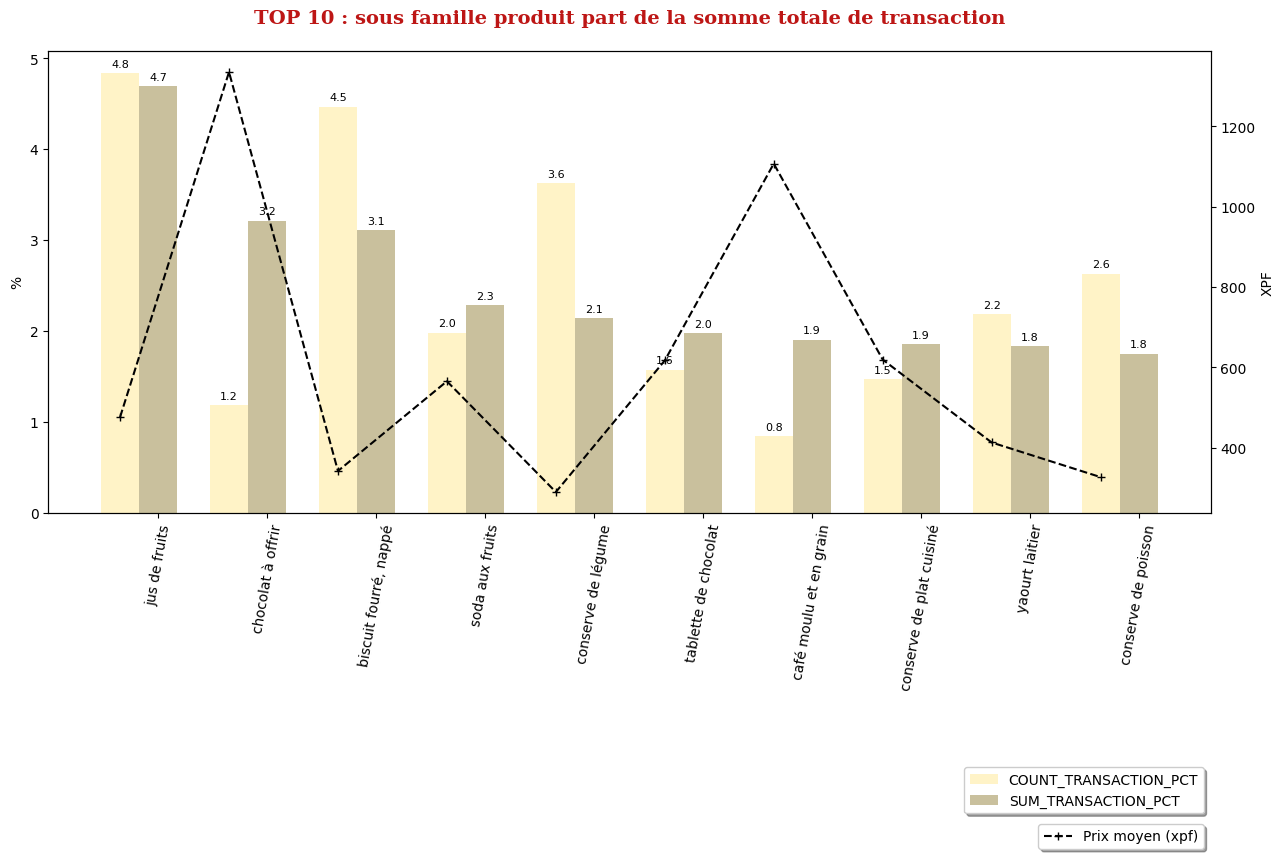

In [34]:
## GRAPHIQUE 5.2
TITLE = "TOP 10 : sous famille produit part de la somme totale de transaction"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 14},pad=20)

## 1
categories = df_rgb_famille_produit_sum_top10.index.to_list()
value = {'COUNT_TRANSACTION_PCT': df_rgb_famille_produit_sum_top10['count_trans_pct'].to_list(),
       'SUM_TRANSACTION_PCT': df_rgb_famille_produit_sum_top10['sum_trans_pct'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0
bar_colors = ['#FFF3C7', '#C9C09D']

i=0
for attribute, measurement in value.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax.bar_label(rects, padding=3, fontsize=8,fmt='%.1f')
    multiplier += 1
    i+=1

ax2 = ax.twinx()
ax2.plot(df_rgb_famille_produit_sum_top10.index.values, df_rgb_famille_produit_sum_top10['avg_trans'], 'black',linestyle='--', marker='+',linewidth=1.5, label='Prix moyen (xpf)')

ax.set_ylabel('%')
ax2.set_ylabel('XPF')

ax.set_xticks(x + width, categories)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=80)
ax.legend(loc="right",bbox_to_anchor=(0,0,1,-1.2), ncol=1, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,1,-1.4), ncol=1, fancybox=True, shadow=True)

In [36]:
# Analyse n°6
df_rgb_famille_produit = df_net.groupby(['VARIETE']).agg(count_trans=('PRIX_RELEVE', 'count'), sum_trans=('PRIX_RELEVE', 'sum'),avg_trans=('PRIX_RELEVE', 'mean'))
df_rgb_famille_produit['count_trans_pct'] = df_rgb_famille_produit['count_trans']/df_rgb_famille_produit['count_trans'].sum()*100
df_rgb_famille_produit['sum_trans_pct'] = df_rgb_famille_produit['sum_trans']/df_rgb_famille_produit['sum_trans'].sum()*100

df_rgb_famille_produit_count_top10=df_rgb_famille_produit.sort_values('count_trans', ascending=False).head(10)
df_rgb_famille_produit_sum_top10=df_rgb_famille_produit.sort_values('sum_trans', ascending=False).head(10)
df_rgb_famille_produit_avg_top10=df_rgb_famille_produit.sort_values('avg_trans', ascending=False).head(10)

global_variete_count_top10 = df_rgb_famille_produit_count_top10.index.to_list()
global_variete_sum_top10 = df_rgb_famille_produit_sum_top10.index.to_list()
global_variete_avg_top10 = df_rgb_famille_produit_avg_top10.index.to_list()

#  'SOUS_SECTEUR_CONSO', 'FAMILLE_PRODUIT', 'SOUS_FAMILLE', 'VARIETE',

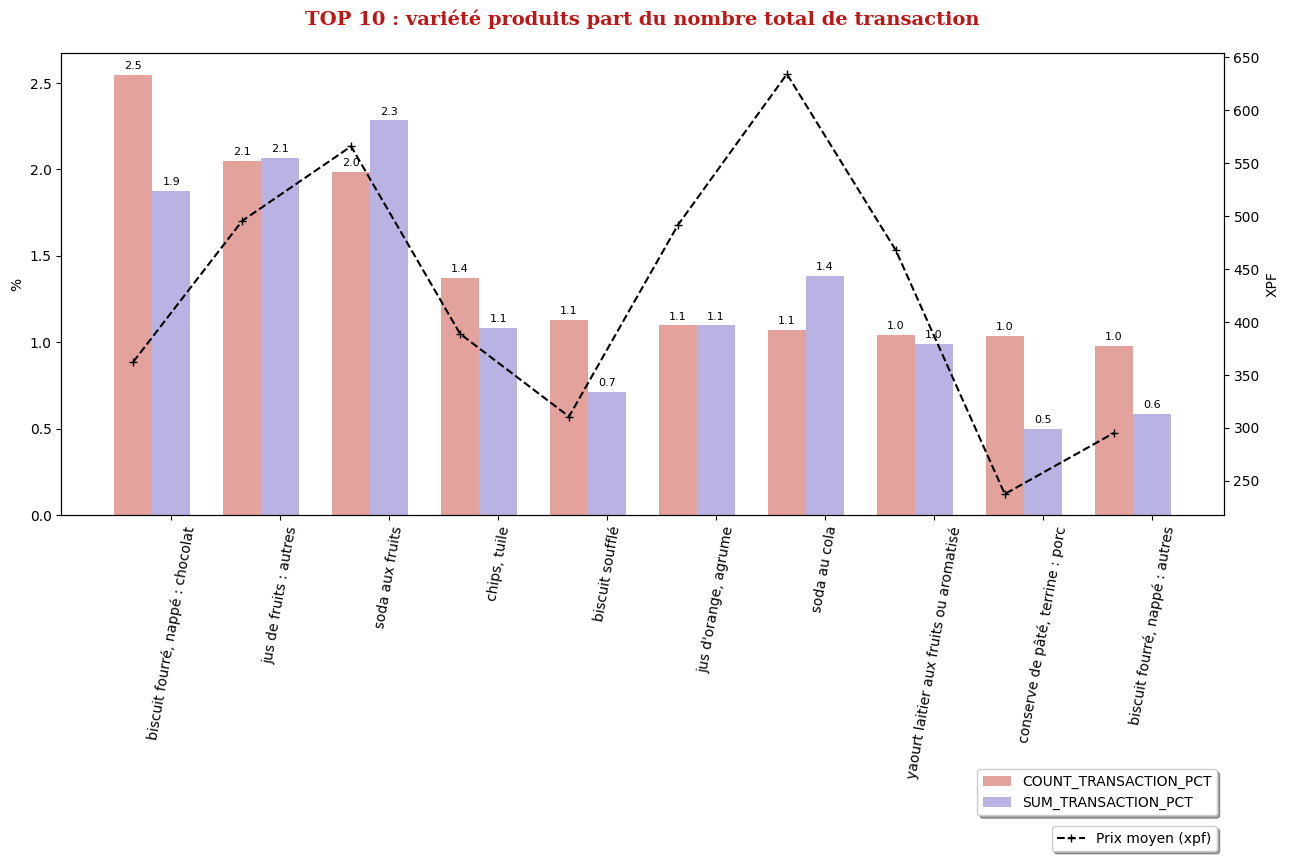

In [37]:
## GRAPHIQUE 6.1
TITLE = "TOP 10 : variété produits part du nombre total de transaction"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 14},pad=20)

## 1
categories = df_rgb_famille_produit_count_top10.index.to_list()
value = {'COUNT_TRANSACTION_PCT': df_rgb_famille_produit_count_top10['count_trans_pct'].to_list(),
       'SUM_TRANSACTION_PCT': df_rgb_famille_produit_count_top10['sum_trans_pct'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0
bar_colors = ['#E3A29B', '#B8B3E3']

i=0
for attribute, measurement in value.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax.bar_label(rects, padding=3, fontsize=8,fmt='%.1f')
    multiplier += 1
    i+=1

ax2 = ax.twinx()
ax2.plot(df_rgb_famille_produit_count_top10.index.values, df_rgb_famille_produit_count_top10['avg_trans'], 'black',linestyle='--', marker='+',linewidth=1.5, label='Prix moyen (xpf)')

ax.set_ylabel('%')
ax2.set_ylabel('XPF')

ax.set_xticks(x + width, categories)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=80)
ax.legend(loc="right",bbox_to_anchor=(0,0,1,-1.2), ncol=1, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,1,-1.4), ncol=1, fancybox=True, shadow=True)

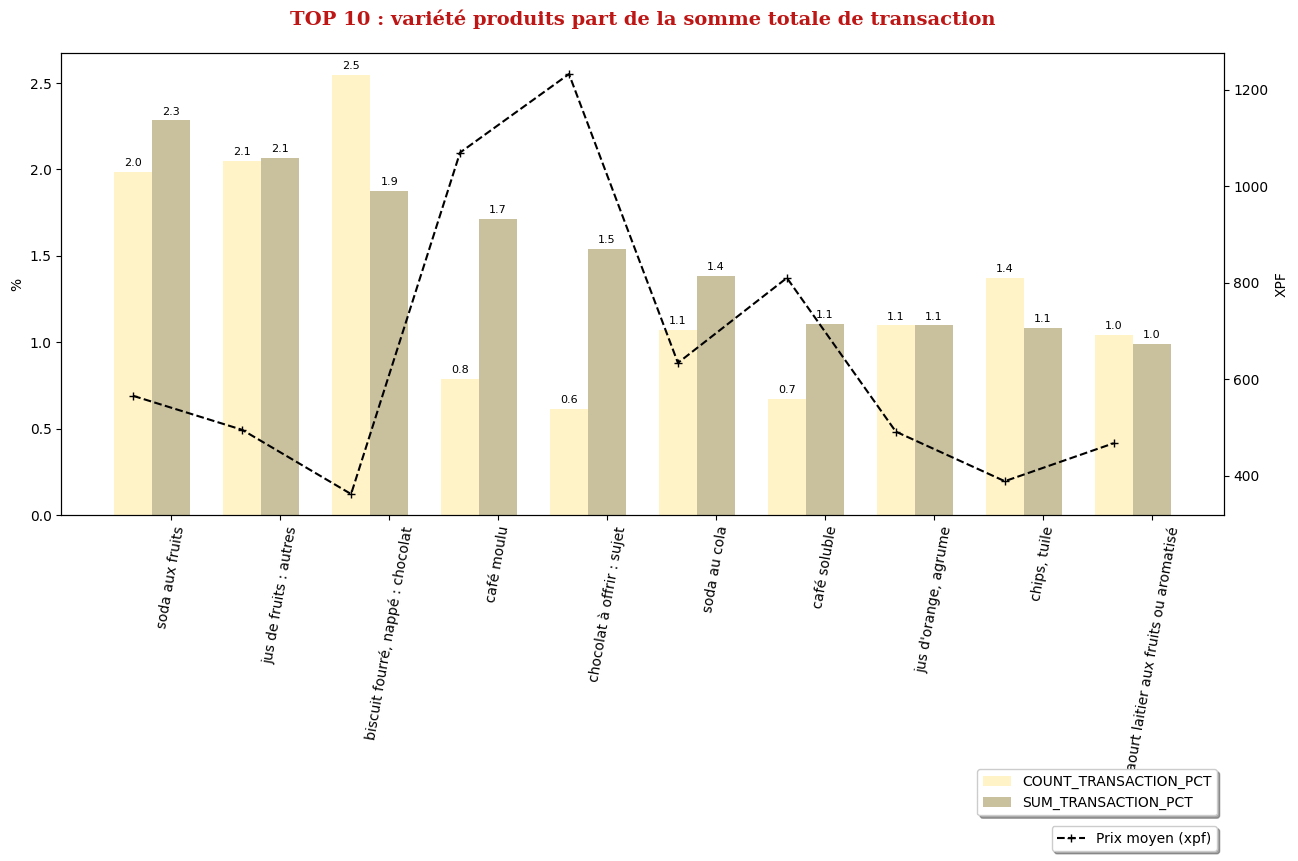

In [38]:
## GRAPHIQUE 6.2
TITLE = "TOP 10 : variété produits part de la somme totale de transaction"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
fig.subplots_adjust(hspace=0.05)
plt.xticks(rotation=90)
ax.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 14},pad=20)

## 1
categories = df_rgb_famille_produit_sum_top10.index.to_list()
value = {'COUNT_TRANSACTION_PCT': df_rgb_famille_produit_sum_top10['count_trans_pct'].to_list(),
       'SUM_TRANSACTION_PCT': df_rgb_famille_produit_sum_top10['sum_trans_pct'].to_list(),
        }

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0
bar_colors = ['#FFF3C7', '#C9C09D']

i=0
for attribute, measurement in value.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=bar_colors[i])
    ax.bar_label(rects, padding=3, fontsize=8,fmt='%.1f')
    multiplier += 1
    i+=1

ax2 = ax.twinx()
ax2.plot(df_rgb_famille_produit_sum_top10.index.values, df_rgb_famille_produit_sum_top10['avg_trans'], 'black',linestyle='--', marker='+',linewidth=1.5, label='Prix moyen (xpf)')

ax.set_ylabel('%')
ax2.set_ylabel('XPF')

ax.set_xticks(x + width, categories)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=80)
ax.legend(loc="right",bbox_to_anchor=(0,0,1,-1.2), ncol=1, fancybox=True, shadow=True)
ax2.legend(loc="right",bbox_to_anchor=(0,0,1,-1.4), ncol=1, fancybox=True, shadow=True)

In [82]:
# Analyse n°8
# df_net_y = df_net[-df_net["ANNEE"].isin(["2012"])]
df_year = df_net.groupby(['ANNEE']).agg(avg_trans=('PRIX_RELEVE', 'mean'))
df_year['TAUX_VARIATION'] = (df_year['avg_trans']-df_year['avg_trans'].iloc[0])/df_year['avg_trans'].iloc[0]*100
# print(df_year)
df_secteur_year = df_net.groupby(['VARIETE','ANNEE']).agg(avg_trans=('PRIX_RELEVE', 'mean'))
df_secteur_year_pivot = df_secteur_year.pivot_table(columns='VARIETE', index='ANNEE', values='avg_trans')
df_secteur_year_pivot = df_secteur_year_pivot.fillna(method='bfill')
df_secteur_year_pivot = df_secteur_year_pivot.iloc[:, :].apply(lambda x: (x-x.iloc[0])/x.iloc[0]*100)
# print(df_secteur_year_pivot)
#  'SOUS_SECTEUR_CONSO', 'FAMILLE_PRODUIT', 'SOUS_FAMILLE', 'VARIETE',

C:\Users\Sloutmyv\AppData\Local\Temp\ipykernel_18500\1216374547.py:28: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in leg.legendHandles:


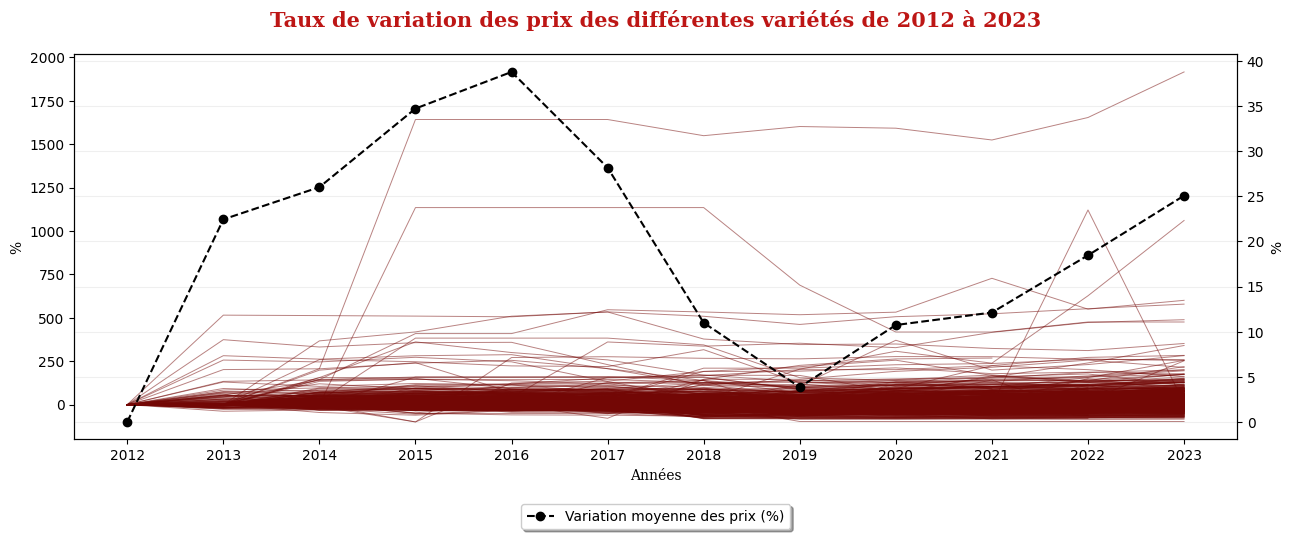

In [84]:
## GRAPHIQUE 8.1
TITLE = "Taux de variation des prix des différentes variétés de 2012 à 2023" # Titre de la figure

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,5)) # Nombre et disposition des zones de dessin
fig.subplots_adjust(hspace=0.02)

# Zone 2
axes.set_title(TITLE, fontdict={'family': 'serif','color' : '#BD1615','weight': 'bold','size': 15},pad=20)
axes.set_xlabel("Années", fontdict={'family': 'serif','color' : 'black','weight': 'light','size': 10})
axes.set_ylabel("%", fontdict={'family': 'serif','color' : 'black','weight': 'light','size': 10})


i = 0
for alim in df_secteur_year_pivot.columns.to_list():
    axes.plot(df_secteur_year_pivot.index.values,df_secteur_year_pivot[alim],color='#730705',linewidth=0.7,alpha=0.5)
    i+=1


ax2 = axes.twinx()
ax2.grid(True,alpha=0.2)
ax2.plot(df_year.index.values,df_year['TAUX_VARIATION'],'black',linestyle='--', marker='o',linewidth=1.5,label='Variation moyenne des prix (%)')
ax2.set_ylabel('%')

# Légende
ax2.legend(loc="center",bbox_to_anchor=(0,0,1,-0.4), ncol=3, fancybox=True, shadow=True)

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.5)

In [ ]:
# fig = plt.figure(figsize=(15, 15))

# m = Basemap(projection = 'ortho', lon_0 = 166, lat_0 = -24.5,
#             llcrnrx=-300000, llcrnry=190000, urcrnrx=300000, urcrnry=560000, 
#             resolution = 'h')

# m.drawcoastlines(linewidth = 1)
# m.drawcountries()

# # 2. scatter city data, with color reflecting population
# # and size reflecting area
# m.scatter(df_gb_loc.lon, df_gb_loc.lat, latlon=True,
#           c=np.log10(df_gb_loc.PRIX_RELEVE), s=df_gb_loc.RAISON_SOCIALE*2,
#           cmap='Reds', alpha=0.5)

# # 3. create colorbar and legend
# plt.colorbar(label=r'$\log_{10}({\rm nombre de transaction})$')
# # plt.clim(3, 7)

# # make legend with dummy points
# for a in [5, 50, 500]:
#     plt.scatter([], [], c='k', alpha=0.5, s=a*2,
#                 label=str(a) + ' enseignes')
# plt.legend(scatterpoints=1, frameon=False,
#            labelspacing=1, loc='lower left');